In [2]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation
import random

In [3]:
beta_c = 0.5 * math.log(1+2**0.5)

In [4]:
def config_gen(N):
    """ A function to generate a random configuration of the Ising 
        Model of size N by N"""
    matrix = np.random.randint(2, size=(N,N))
    config = np.where(matrix == 0, matrix-1, matrix)
    return(config)



def gibbs(config,beta,h):
    """ A function that gives a full gibbs update for the Ising Model 
        given some inverse temperature beta and external magnetic field h"""
    
    N = np.shape(config)[0]
    linear_indices = np.asarray(range(N**2),dtype=int)
    random.shuffle(linear_indices)
    lattice_sites = [(ell//N,ell%N) for ell in linear_indices]
    
    for (i,j) in lattice_sites:
        
    # Update spin (i,j) with Gibbs sample
        node = np.array([i,j])
    
        delta = -1*(config[(node[0]+1)%N,node[1]]+config[(node[0]-1)%N,node[1]]+config[node[0],(node[1]+1)%N]+config[node[0],(node[1]-1)%N]+h)
        q = 1/(1+math.exp(2*beta*delta))
    
        #the rejection bit
        U = np.random.uniform()
        if U < q:
            config[node[0],node[1]] = 1
        else:
            config[node[0],node[1]] = -1


In [27]:
def compute_S(config,proposal,beta,h,blue_sites,red_sites):
    
    #now were going to compute just S not exp(S)
    N = np.shape(config)[0]
    
    #full ratio
    config_energy = 0
    proposal_energy = 0
    
    for i in range(N):
        for j in range(N):
            energy_chunk_config = -0.5*config[i,j]*(config[(i+1)%N,j]+config[(i-1)%N,j]+config[i,(j+1)%N]+config[i,(j-1)%N]) - h*config[i,j]
            energy_chunk_proposal = -0.5*proposal[i,j]*(proposal[(i+1)%N,j]+proposal[(i-1)%N,j]+proposal[i,(j+1)%N]+proposal[i,(j-1)%N]) - h*proposal[i,j]
            config_energy = config_energy + energy_chunk_config
            proposal_energy = proposal_energy + energy_chunk_proposal
            
    frac_1 = -beta *(proposal_energy-config_energy)
    
    
    #coarse ratio
    coarse_config = config[::2,::2]
    coarse_proposal = proposal[::2,::2]
    
    coarse_config_energy = 0
    coarse_proposal_energy = 0
    coarse_N = int(N/2)
    for i in range(coarse_N):
        for j in range(coarse_N):
            energy_chunk_coarse_config = -0.5*coarse_config[i,j]*(coarse_config[(i+1)%coarse_N,j]+coarse_config[(i-1)%coarse_N,j]+coarse_config[i,(j+1)%coarse_N]+coarse_config[i,(j-1)%coarse_N]) - h*coarse_config[i,j]
            energy_chunk_coarse_proposal = -0.5*coarse_proposal[i,j]*(coarse_proposal[(i+1)%coarse_N,j]+coarse_proposal[(i-1)%coarse_N,j]+coarse_proposal[i,(j+1)%coarse_N]+coarse_proposal[i,(j-1)%coarse_N]) - h*coarse_proposal[i,j]
            coarse_config_energy = coarse_config_energy + energy_chunk_coarse_config
            coarse_proposal_energy = coarse_proposal_energy + energy_chunk_coarse_proposal
            
    frac_4 = -beta *(coarse_config_energy-coarse_proposal_energy)
    
    #blue_ratio
    config_sum_blue = 0
    proposal_sum_blue = 0
    
    for (i,j) in blue_sites:
        config_delta = -1*(config[(i+1)%N,(j+1)%N]+config[(i-1)%N,(j-1)%N]+config[(i-1)%N,(j+1)%N]+config[(i+1)%N,(j-1)%N]+h)
        proposal_delta = -1*(proposal[(i+1)%N,(j+1)%N]+proposal[(i-1)%N,(j-1)%N]+proposal[(i-1)%N,(j+1)%N]+proposal[(i+1)%N,(j-1)%N]+h)
        
        config_sum_blue += -np.log(1+np.exp(2*beta*config[i,j]*config_delta))
        proposal_sum_blue += -np.log(1+np.exp(2*beta*proposal[i,j]*proposal_delta)) 
        
    frac_3 = config_sum_blue - proposal_sum_blue
    
    #red ratio
    config_sum_red = 0
    proposal_sum_red = 0
    
    for (i,j) in red_sites:
        config_delta = -1*(config[i,(j+1)%N]+config[i,(j-1)%N]+config[(i-1)%N,j]+config[(i+1)%N,j]+h)
        proposal_delta = -1*(proposal[i,(j+1)%N]+proposal[i,(j-1)%N]+proposal[(i-1)%N,j]+proposal[(i+1)%N,j]+h)
        
        config_sum_red += np.log(1/(1+np.exp(2*beta*config[i,j]*config_delta)))
        proposal_sum_red += np.log(1/(1+np.exp(2*beta*proposal[i,j]*proposal_delta))) 
        
    frac_2 = config_sum_red - proposal_sum_red
    return(frac_1+frac_2+frac_3+frac_4)

In [30]:
def ising_2d_hierarchical(level,config,beta,h,info=0):
    N = np.shape(config)[0]
    proposal = config.copy() #initiate the proposal
    #split up the indices
    #full
    linear_indices = np.asarray(range(N**2),dtype=int)
    lattice_sites = [(ell//N,ell%N) for ell in linear_indices]
    #coarse
    coarse_sites = [(i,j) for i in range(0,N,2) for j in range(0,N,2)]
    #blue
    blue_sites = [(i,j) for i in range(1,N,2) for j in range(1,N,2)]
    #red
    red_sites = lattice_sites.copy()
    for i in range(len(blue_sites)):
        red_sites.remove(blue_sites[i])
    for i in range(len(coarse_sites)):
        red_sites.remove(coarse_sites[i])
    
    #sample coarse
    #for now we use a gibbs sampler here
    
    if (level == 1):
        gibbs(proposal,beta,h)
        info = 0
        return(proposal,info)
    
    else:
        proposal[::2,::2],info = ising_2d_hierarchical(level-1,proposal[::2,::2],beta,h,info)
        if (info == 1):
            return(config,info)
        else:
            #sample blue
            for (i,j) in blue_sites:
                delta = -1*(proposal[(i+1)%N,(j+1)%N]+proposal[(i-1)%N,(j-1)%N]+proposal[(i-1)%N,(j+1)%N]+proposal[(i+1)%N,(j-1)%N]+h)
                q = 1/(1+math.exp(2*beta*delta))
        
                #the rejection bit
                U = np.random.uniform()
                if U < q:
                    proposal[i,j] = 1
                else:
                    proposal[i,j] = -1
            
            
            #sample red
            for (i,j) in red_sites:
                delta = -1*(proposal[i,(j+1)%N]+proposal[i,(j-1)%N]+proposal[(i-1)%N,j]+proposal[(i+1)%N,j]+h)
                q = 1/(1+math.exp(2*beta*delta))
        
                #the rejection bit
                U = np.random.uniform()
                if U < q:
                    proposal[i,j] = 1
                else:
                    proposal[i,j] = -1
    
    
            #sample rejection
            S = compute_S(config,proposal,beta,h,blue_sites,red_sites) #computing S - returns -Delta S_ell
    
            if (-1*S<0):
                sample = proposal.copy()
                info =0
            else:
                U = np.random.uniform()
                if (U < np.exp(S)):
                    sample = proposal.copy()
                    info = 0
                else:
                    sample = config.copy()
                    info = 1
    
            return(sample,info)



In [29]:
config_0 = np.ones((16,16))

config,info = ising_2d_hierarchical(2,config_0,beta_c,0)

info

gibbs step


0

# acceptance rates

In [31]:
def acceptance_hierarchical(N_vec,beta,h,T,level,burn_in=0):
    """ A function to sample the magentism for an Ising model with
        a given inverse temp beta and external field h, where T is 
        the number of samples required"""
    print('level = ', level)
    for N in N_vec:
        current_config = config_gen(N)
        #current_config = np.ones((N,N))
        info_sum = 0
    
        for i in range(0,burn_in):
            current_config,info = ising_2d_hierarchical(level,current_config,beta,h)
        
        for i in range(1,T+1):
            current_config,info = ising_2d_hierarchical(level,current_config,beta,h)
            info_sum = info_sum + info
        print('acceptance rate for N=',N,':', 1-(info_sum/T))
        
    return()

In [32]:
N_vec = np.array([16])
acceptance_hierarchical(N_vec,beta_c,0,10000,2,10000)

level =  2
acceptance rate for N= 16 : 0.2489


()

In [9]:
N_vec = np.array([8,16,32])
acceptance_hierarchical(N_vec,beta_c,0,10000,3,10000)

level =  3
acceptance rate for N= 8 : 0.44010000000000005
acceptance rate for N= 16 : 0.0
acceptance rate for N= 32 : 0.0


()

In [10]:
N_vec = np.array([16,32])
acceptance_hierarchical(N_vec,beta_c,0,10000,4,10000)

level =  4
acceptance rate for N= 16 : 0.0
acceptance rate for N= 32 : 0.0


()

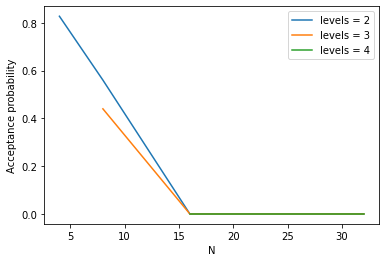

In [27]:
vec_2 = np.array([0.8279,0.5605,0.0,0.0])
vecN2 = np.array([4,8,16,32])
   
vec_3 = np.array([0.44010000000000005,0.0,0.0])
vecN3 = np.array([8,16,32])    
    
vec_4 = np.array([0.0,0.0])
vecN4 = np.array([16,32])  

plt.plot(vecN2,vec_2,label = 'levels = 2')
plt.plot(vecN3,vec_3,label = 'levels = 3')
plt.plot(vecN4,vec_4,label = 'levels = 4')
plt.xlabel('N')
plt.ylabel('Acceptance probability')
plt.legend()
plt.show()

# testing using observables

In [35]:
def mc_susceptibility_hierarchical(config_0,beta,h,T,level,burn_in=0):
    """ A function to sample the magentism for an Ising model with
        a given inverse temp beta and external field h, where T is 
        the number of samples required"""
    
    N = np.shape(config_0)[0]
    
    mu = 0
    mu_2 = 0
    mu_4 = 0
    
    current_config = config_0
    info_sum = 0
    
    for i in range(0,burn_in):
        current_config,info = ising_2d_hierarchical(level,current_config,beta,h)
        
    for i in range(1,T+1):
        current_config,info = ising_2d_hierarchical(level,current_config,beta,h)
        Q = np.mean(current_config)
        mu = mu + (Q-mu)/i
        mu_2 = mu_2 + (Q**2-mu_2)/i
        mu_4 = mu_4 + (Q**4-mu_4)/i
        info_sum = info_sum + info
    
    susceptibility = beta * (mu_2 - mu**2)
    error = beta * np.sqrt((mu_4-mu_2**2)/(T-1)+ 4* mu**2*((mu_2-mu**2)/(T-1)))
    
    print('susceptibility: ',susceptibility)
    print('error: ',error)
    print('acceptance rate:', 1-(info_sum/T))
    return(susceptibility,error)

In [36]:
#two level tests

In [37]:
config_0 = config_gen(4)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,2,burn_in=10000)

susceptibility:  0.33511768797846325
error:  0.0013936107339812141
acceptance rate: 0.833


(0.33511768797846325, 0.0013936107339812141)

In [38]:
config_0 = config_gen(8)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,2,burn_in=10000)

susceptibility:  0.2909078539922147
error:  0.0011136175282494565
acceptance rate: 0.5862


(0.2909078539922147, 0.0011136175282494565)

In [39]:
config_0 = config_gen(16)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,2,burn_in=10000)

susceptibility:  0.0
error:  0.0
acceptance rate: 0.0


(0.0, 0.0)

In [40]:
config_0 = config_gen(32)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,2,burn_in=10000)

susceptibility:  0.0
error:  0.0
acceptance rate: 0.0


(0.0, 0.0)

In [41]:
# 3 level tests

In [42]:
config_0 = config_gen(8)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,3,burn_in=10000)


susceptibility:  0.2803419292914257
error:  0.0011691371648537043
acceptance rate: 0.4233


(0.2803419292914257, 0.0011691371648537043)

In [43]:
config_0 = config_gen(16)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,3,burn_in=10000)



susceptibility:  0.0
error:  0.0
acceptance rate: 0.0


(0.0, 0.0)

In [44]:
config_0 = config_gen(32)
mc_susceptibility_hierarchical(config_0,beta_c,0,10000,3,burn_in=10000)



susceptibility:  0.0
error:  0.0
acceptance rate: 0.0


(0.0, 0.0)

# samples for the corr sus

In [34]:
def mc_hier_susceptibility_for_IACT(config_0,beta,h,T,level,burn_in=0):
    """ A function to sample the susceptibility for an Ising model with
        a given inverse temp beta and external field h, where T is 
        the number of samples required"""
    
    N = np.shape(config_0)[0]
    samples = np.empty(0) #create an empty vector to store the samples

    current_config = config_0
    info_sum = 0
    
    for i in range(burn_in):
        current_config,info = ising_2d_hierarchical(level,current_config,beta,h)
        
    for i in range(T):
        current_config,info = ising_2d_hierarchical(level,current_config,beta,h)
        samples = np.append(samples,beta*np.mean(current_config)**2)
        info_sum += info
        
    print('acceptance rate:',1-info_sum/T)
    return(samples)

In [10]:
config_4 = config_gen(4)
config_8 = config_gen(8)

samples_beta_c_4_sus_hierl2 = mc_hier_susceptibility_for_IACT(config_4,beta_c,0,10000,2,burn_in=10000)
np.save("samples_beta_c_4_sus_hierl2", samples_beta_c_4_sus_hierl2)
print('samples done')
samples_beta_c_8_sus_hierl2 = mc_hier_susceptibility_for_IACT(config_8,beta_c,0,10000,2,burn_in=10000)
np.save("samples_beta_c_8_sus_hierl2", samples_beta_c_8_sus_hierl2)
print('samples done')
samples_beta_c_8_sus_hierl3 = mc_hier_susceptibility_for_IACT(config_8,beta_c,0,10000,3,burn_in=10000)
np.save("samples_beta_c_8_sus_hierl3", samples_beta_c_8_sus_hierl3)

rejection: 0.8132
samples done
rejection: 0.5527
samples done
rejection: 0.4094


In [15]:
config_16 = config_gen(16)
samples_beta_c_16_sus_hierl2 = mc_hier_susceptibility_for_IACT(config_16,beta_c,0,10000,2,burn_in=10000)
np.save("samples_beta_c_16_sus_hierl2", samples_beta_c_16_sus_hierl2)

rejection: 0.0027000000000000357


In [16]:
config_16 = config_gen(16)
samples_beta_c_16_sus_hierl3 = mc_hier_susceptibility_for_IACT(config_16,beta_c,0,10000,3,burn_in=10000)
np.save("samples_beta_c_16_sus_hierl3", samples_beta_c_16_sus_hierl3)

rejection: 0.0


In [42]:
config_16 = np.ones((16,16))
samples_beta_c_16_sus_hierl2_allones = mc_hier_susceptibility_for_IACT(config_16,beta_c,0,10000,2,burn_in=10000)
np.save("samples_beta_c_16_sus_hierl2_allones", samples_beta_c_16_sus_hierl2_allones)

acceptance rate: 0.26949999999999996


In [43]:
def error(samples,beta):
    error = beta * np.sqrt(np.var(samples/beta))
    return(error)


In [44]:
samples = samples_beta_c_16_sus_hierl2_allones

In [45]:
sus = np.mean(samples)
error = error(samples,beta_c)
print('sus:',sus)
print('error:',error)

sus: 0.2425515823137051
error: 0.10155068439141343


In [47]:
import pylab

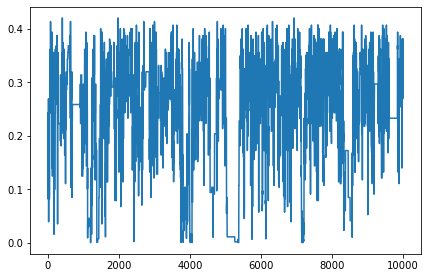

In [48]:
#4

fig = plt.figure(figsize=(7, 10))
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(samples)


pylab.show()